In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from functools import partial

with open("data/aspartam_similar_CFMID4.0.json", mode = "r") as drugbank:
    db = json.load(drugbank)

2021-12-23 21:20:21.480595: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-23 21:20:21.480630: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
from tqdm.notebook import tqdm
%matplotlib inline
point_clouds = list()
for m,ms in tqdm(list(db.items())):
    try:
        ms.pop("frag")
    except KeyError:
        pass
    
    sigma = 19
    num = 1000
    max_mass = max([ max( db[m][e]["mz"] ) for e in ms.keys() ])
    min_mass = min([ min( db[m][e]["mz"] ) for e in ms.keys() ])
    x = np.linspace(
        min_mass,
        max_mass,
        num = num
    )

    mixtures = np.zeros((num, len(ms.values()) ))
    for idx, energy in enumerate(ms.values()):            
        mix = [
            intens * np.exp(-.5*np.power((x - peak)/sigma,2))
            for peak,intens in zip(energy["mz"], energy["intens"])
        ]
        mix = np.sum(mix, axis = 0)
        mixtures[:,idx] = mix / mix.max()
    point_clouds.append(mixtures)

  0%|          | 0/10 [00:00<?, ?it/s]

In [3]:
point_clouds = list(map(
    partial(tf.convert_to_tensor, dtype = tf.float32),
    point_clouds
))

2021-12-23 21:20:23.913166: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-12-23 21:20:23.913236: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-23 21:20:23.913278: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (UX305FA): /proc/driver/nvidia/version does not exist
2021-12-23 21:20:23.913819: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


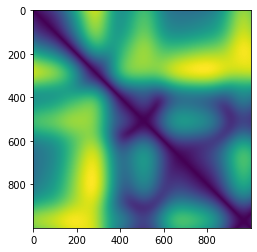

In [8]:
def tf_distance_matrix(ms):
    t1 = tf.reshape(ms, (1,ms.shape[0],ms.shape[1]))
    t2 = tf.reshape(ms, (ms.shape[0],1,ms.shape[1]))
    return tf.norm(t1-t2, ord='euclidean', axis=2,)

mxs = list(map(
    tf_distance_matrix,
    point_clouds
))
mx = mxs[0]
plt.imshow(mx)
